<a href="https://colab.research.google.com/github/maltevolle/PMML-Project/blob/animals-10/Project_PMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets


In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from datasets import load_dataset
import random



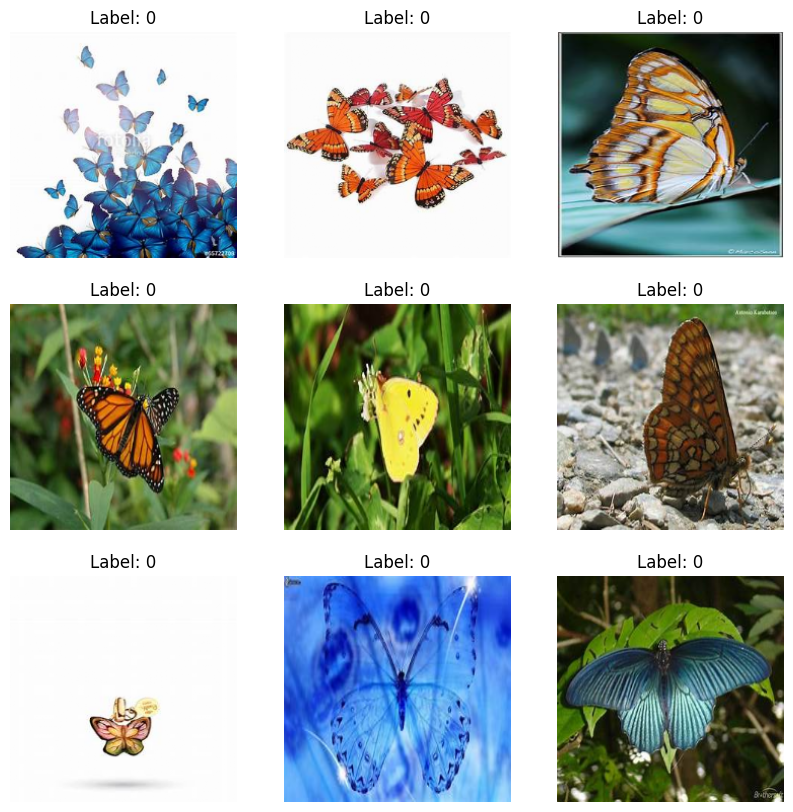

In [22]:
ds = load_dataset("Rapidata/Animals-10")


# Funktion zum Konvertieren in TensorFlow Dataset
def transform_to_tf(example):
    image = tf.image.resize(example["image"], [224, 224])  # Resize
    image = tf.cast(image, tf.float32) / 255.0  # Normalisierung
    label = tf.convert_to_tensor(example["label"], dtype=tf.int32)
    return image, label


# Umwandlung für Train/Test/Valid-Sets
train_data = tf.data.Dataset.from_generator(
    lambda: (transform_to_tf(ex) for ex in ds["train"]),
    output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_generator(
    lambda: (transform_to_tf(ex) for ex in ds["test"]),
    output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(32).prefetch(tf.data.AUTOTUNE)



plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):  # Ein Batch nehmen
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
plt.show()




Der Code missklassifiziert die bilder von cats vs dogs mit imagenet. Ich weiß nicht so ganz was der macht aber es funktioniert :)

Verfügbare Splits: dict_keys(['train'])
Trainingsdaten: 18843, Testdaten: 4711
Verarbeitung von Testdaten mit FGSM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
Original prediction: ('n02389026', 'sorrel', 1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Adversarial prediction: ('n03291819', 'envelope', 0.14558497)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Original prediction: ('n03125729', 'cradle', 1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Adversarial prediction: ('n03888257', 'parachute', 0.049323957)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Original prediction: ('n02111129', 'Leonberg', 0.6555556)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Adversarial prediction: ('n03888257', 'parachute', 0.06077814)
Verarbeitung von Testdaten mit PGD...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Original prediction: ('n02389026', 'sorrel', 0.9991066)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
Adversarial prediction: ('n03676483', 'lipstick', 0.58510303)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Original prediction: ('n0228

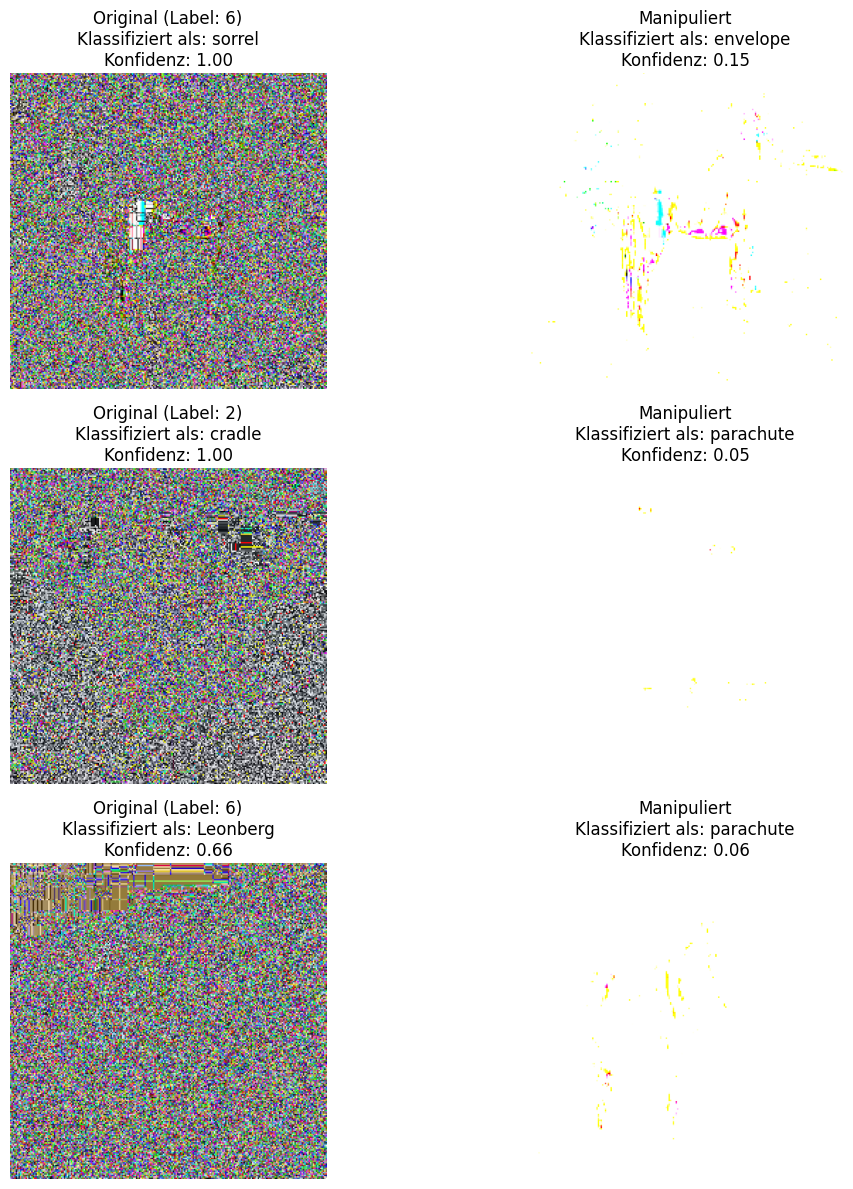

PGD Resultate...


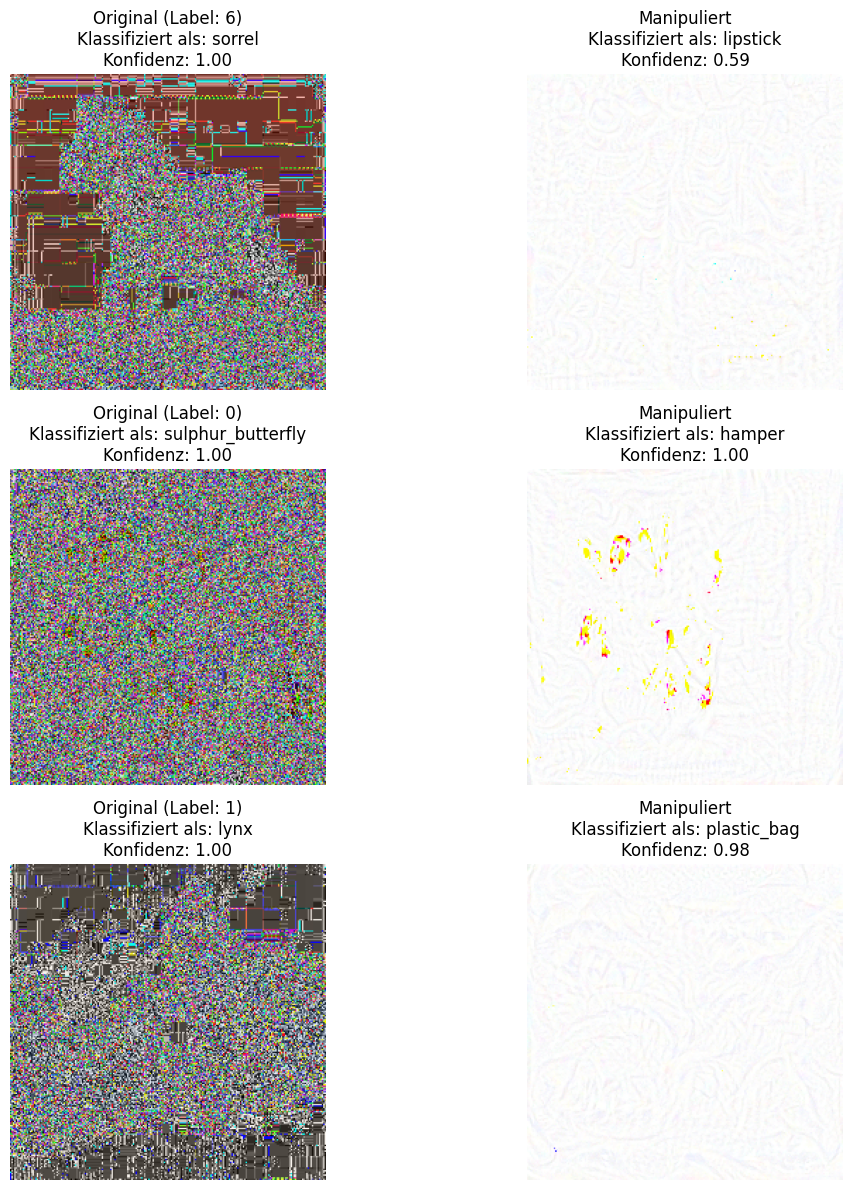

In [19]:
# Laden des vortrainierten Modells
model = VGG16(weights='imagenet')

def load_animals10_dataset():
    """Lädt das Animals-10 Dataset von Hugging Face und teilt es in Train/Test auf"""
    dataset = load_dataset("Rapidata/Animals-10")

    # Prüfen, welche Splits existieren
    print("Verfügbare Splits:", dataset.keys())  # Gibt die vorhandenen Splits aus

    # Falls nur 'train' existiert, manuell aufteilen
    full_data = dataset["train"]  # Der gesamte Datensatz
    split_ratio = 0.8  # 80% Training, 20% Test

    # Zufällige Permutation der Daten für eine faire Aufteilung
    shuffled_data = full_data.shuffle(seed=42)
    train_size = int(len(shuffled_data) * split_ratio)

    train_data = shuffled_data.select(range(train_size))
    test_data = shuffled_data.select(range(train_size, len(shuffled_data)))

    print(f"Trainingsdaten: {len(train_data)}, Testdaten: {len(test_data)}")

    return train_data, test_data


def preprocess_image(image, label):
    """Bereitet ein einzelnes Bild für VGG16 vor"""
    image = tf.image.resize(image, (224, 224))  # Resize auf 224x224
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normierung auf [0, 1]
    image = image * 255  # Anpassung für VGG16
    image = tf.expand_dims(image, 0)  # Batch-Dimension hinzufügen
    return image, label

def create_adversarial_image(image, target_class, epsilon=20.0, iterations=10, method="fgsm"):
    """Erstellt ein adversariales Beispiel mit iterativem Angriff"""
    image_tensor = tf.convert_to_tensor(image)
    adv_image = tf.identity(image_tensor)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            processed_image = preprocess_input(adv_image)
            prediction = model(processed_image)
            loss = -tf.keras.losses.SparseCategoricalCrossentropy()(tf.constant([target_class]), prediction)

        gradient = tape.gradient(loss, adv_image)
        signed_gradient = tf.sign(gradient)

        if method == "fgsm":
            adv_image = adv_image + epsilon * signed_gradient
            break
        elif method == "pgd":
            adv_image = adv_image + (epsilon / iterations) * signed_gradient
            adv_image = tf.clip_by_value(adv_image, 0, 255)

    adv_image = tf.clip_by_value(adv_image, 0, 255)
    return adv_image

def predict_class(image_array):
    """Vorhersage der Klasse mit VGG16"""
    processed_image = preprocess_input(tf.cast(image_array, tf.float32))
    predictions = model.predict(processed_image)
    decoded_predictions = tf.keras.applications.vgg16.decode_predictions(predictions, top=3)[0]
    return decoded_predictions[0]

def process_dataset_samples(dataset, num_samples=3, attack_type="fgsm"):
    """Verarbeitet Beispiele aus dem Dataset"""
    results = []
    selected_samples = random.sample(list(dataset), num_samples)

    for sample in selected_samples:
        image = np.array(sample["image"])
        label = sample["label"]

        image, _ = preprocess_image(image, label)

        # Original klassifizieren
        original_pred = predict_class(image)
        print(f"Original prediction: {original_pred}")

        # Zufällige Target-Klasse setzen
        target_class = random.choice(range(1000))  # VGG16 hat 1000 Klassen

        adversarial_img = create_adversarial_image(
            image, target_class, epsilon=20.0, iterations=10 if attack_type == "pgd" else 1, method=attack_type
        )
        adversarial_pred = predict_class(adversarial_img)
        print(f"Adversarial prediction: {adversarial_pred}")

        results.append({
            'original_img': image,
            'adversarial_img': adversarial_img,
            'original_pred': original_pred,
            'adversarial_pred': adversarial_pred,
            'true_class': label
        })

    return results

def plot_results(results):
    """Visualisiert die Ergebnisse"""
    n = len(results)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

    if n == 1:
        axes = axes.reshape(1, -1)

    for i, result in enumerate(results):
        orig_img = result['original_img'][0].numpy()  # Tensor zu NumPy konvertieren
        axes[i, 0].imshow(orig_img.astype(np.uint8))  # Bild anzeigen
        axes[i, 0].set_title(f'Original (Label: {result["true_class"]})\n'
                            f'Klassifiziert als: {result["original_pred"][1]}\n'
                            f'Konfidenz: {result["original_pred"][2]:.2f}')

        adv_img = result['adversarial_img'][0].numpy()  # Tensor zu NumPy konvertieren
        axes[i, 1].imshow(adv_img.astype(np.uint8))  # Bild anzeigen
        axes[i, 1].set_title(f'Manipuliert\n'
                            f'Klassifiziert als: {result["adversarial_pred"][1]}\n'
                            f'Konfidenz: {result["adversarial_pred"][2]:.2f}')

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# Hauptprogramm
if __name__ == "__main__":
    train_data, test_data = load_animals10_dataset()

    print("Verarbeitung von Testdaten mit FGSM...")
    fgsm_results = process_dataset_samples(test_data, num_samples=3, attack_type="fgsm")

    print("Verarbeitung von Testdaten mit PGD...")
    pgd_results = process_dataset_samples(test_data, num_samples=3, attack_type="pgd")

    print("FGSM Resultate...")
    plot_results(fgsm_results)

    print("PGD Resultate...")
    plot_results(pgd_results)